### Imports

In [1]:
import os
import cv2
import numpy as np
import shutil
import time

from darkflow.net.build import TFNet
from pprint import pprint
from matplotlib import pyplot as plt
from PIL import Image
from boxespredict.yolomodeltest import *

### Setup the .pb file and the .meta file paths

In [2]:
# The protocol buffer file and the .meta file
# NOTE: The .met file is a JSON dump of everything necessary for post-processing such as anchors 
#       and labels
if os.name == 'nt':
    # 30000 steps(Model trained with Udacity Simulator Data)
    #options = {"pbLoad": os.getcwd() + "\\saved_graph\\30000-tiny-yolo-voc-3c.pb", "metaLoad": os.getcwd() + "\\saved_graph\\30000-tiny-yolo-voc-3c.meta", "threshold": 0.1}
    
    # 40375 steps(Model trained with Udacity Simulator Data)
    # options = {"pbLoad": os.getcwd() + "\\saved_graph\\40375-tiny-yolo-voc-3c.pb", "metaLoad": os.getcwd() + "\\saved_graph\\40375-tiny-yolo-voc-3c.meta", "threshold": 0.1}
    
    # 39000 steps(Model trained with Bosch and Udacity Simulator Data)
    #options = {"pbLoad": os.getcwd() + "\\saved_graph\\39000-tiny-yolo-voc-3c.pb", "metaLoad": os.getcwd() + "\\saved_graph\\39000-tiny-yolo-voc-3c.meta", "threshold": 0.1}
    
    # 30000 steps(Model trained with Udacity Simulator and Real Data)
    options = {"pbLoad": os.getcwd() + "\\saved_graph\\30000-SimReal-tiny-yolo-voc-3c.pb", "metaLoad": os.getcwd() + "\\saved_graph\\30000-SimReal-tiny-yolo-voc-3c.meta", "threshold": 0.1}
else:
    # 30000 steps(Model trained with Udacity Simulator Data)
    #options = {"pbLoad": os.getcwd() + "/saved_graph/30000-tiny-yolo-voc-3c.pb", "metaLoad": os.getcwd() + "/saved_graph/30000-tiny-yolo-voc-3c.meta", "threshold": 0.1, "gpu": 1.0}

    #40375 steps(Model trained with Udacity Simulator Data)
    #options = {"pbLoad": os.getcwd() + "/saved_graph/40375-tiny-yolo-voc-3c.pb", "metaLoad": os.getcwd() + "/saved_graph/40375-tiny-yolo-voc-3c.meta", "threshold": 0.1, "gpu": 1.0}
    
    #39000 steps(Model trained with Bosch and Udacity Simulator Data)
    #options = {"pbLoad": os.getcwd() + "/saved_graph/39000-tiny-yolo-voc-3c.pb", "metaLoad": os.getcwd() + "/saved_graph/39000-tiny-yolo-voc-3c.meta", "threshold": 0.1, "gpu": 1.0}
    
    #30000 steps(Model trained with Udacity Simulator and Real Data)
    options = {"pbLoad": os.getcwd() + "/saved_graph/30000-SimReal-tiny-yolo-voc-3c.pb", "metaLoad": os.getcwd() + "/saved_graph/30000-SimReal-tiny-yolo-voc-3c.meta", "threshold": 0.1, "gpu": 1.0}

# Object of Darkflow
tfnet = TFNet(options)


Loading from .pb and .meta
Running entirely on CPU


### Get the predictions from the model for all the images in the sample folder

In [ ]:
# Predictions using darkflow cythonized code and non-cythonized code
predictions_darkflow = {}
predictions_nondarkflow = {}
yolo_test = YOLOTest(options)

'''NOTE: The Pythonized prediction time is ~1.2 - 1.5s where as the cythonized version is < 0.5s on CPU'''
for img_file in os.listdir(os.getcwd() + "\\just_tl_img"):
    file_path = os.getcwd() + "\\just_tl_img\\" + img_file
    imgcv = cv2.imread(file_path)
    #t = time.time()
    #result = tfnet.return_predict(imgcv)
    #print("Cythonized Inference Time %.3f seconds" % (time.time() - t))
    #predictions_darkflow[img_file] = result
    #t = time.time()
    result = return_predict(imgcv, yolo_test)
    #print("Pythonized Inference Time %.3f seconds" % (time.time() - t))
    predictions_nondarkflow[img_file] = result

#pprint(predictions_darkflow)


Loading from .pb and .meta


C:\Users\443615\Documents\SDC\Term3\SystemIntegration\darkflow\tf_light_darkflow_test\boxespredict\boxes.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  net_out = net_out_in.reshape([H, W, B, net_out_in.shape[2]/B])


### Visualize the predictions

In [ ]:
# Specify the image size to display(in inches)
IMAGE_SIZE = (12, 8)

# Function to visualize predictions on an image and store
def visualizePredictions(predictions, source="darkflow"):
    # For each of the annnotations result plot the annotation box and display the image
    for img_file, results in predictions.items():
        # Read the image file
        image_file_path = os.getcwd() + "/just_tl_img/" + img_file
        image = cv2.imread(image_file_path)

        for result in results:
            # Get the top left co-ordinates and insert into a tuple
            x = result['topleft']['x']
            y = result['topleft']['y']
            top_left = (x, y)

            # Get the top left co-ordinates and insert into a tuple
            x = result['bottomright']['x']
            y = result['bottomright']['y']
            bottom_right = (x, y)

            # Get the label and the confidence scores
            label = result['label']
            confidence = result['confidence']

            # Add the bounding boxes and the label with confidence scores if it is above 75%
            if confidence > 0.70:
                if label == "red_rect":
                    label_to_display = "Red"
                    color_to_display = (0, 0, 255)
                elif label == "orange_rect":
                    label_to_display = "Yellow"
                    color_to_display = (0, 255, 255)
                elif label == "green_rect":
                    label_to_display = "Green"
                    color_to_display = (0, 255, 0)

                # Add the rectangle 
                image = cv2.rectangle(image, top_left, bottom_right, color_to_display, 3)

                # Bottom left of text
                bottom_left = (int(image.shape[0]/2) + 20, 20)

                # Add the label
                image = cv2.putText(image, label_to_display, bottom_left, 
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, color_to_display, 1)

        # Write the final file with or without annotations
        cv2.imwrite(annotations_dir + "/" + source + "_" + img_file, image)
        
# Remove existing annotations and create new ones based on the results
#annotations_dir = os.getcwd() + "/sample_img_annotated"
annotations_dir = os.getcwd() + "/just_tl_img_annotated"
if os.path.exists(annotations_dir):
    print("Deleting previous annotations directory")
    shutil.rmtree(annotations_dir)
os.makedirs(annotations_dir)

# Visualize predictions from the cythonized version and the non-cythonized version
#visualizePredictions(predictions_darkflow, "darkflow")
visualizePredictions(predictions_nondarkflow, "nodarkflow")

## Make predictions on the video files


Loading from .pb and .meta


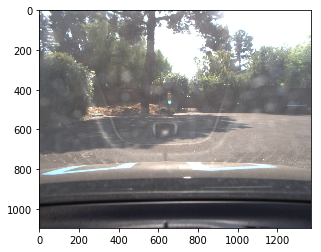

In [3]:
#import matplotlib
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt

# Object of YOLO test to make predictions
yolo_test = YOLOTest(options)

# Takes an image, detects the traffic lights and draws the predictions on the image
def process_image(image):
    plt.imshow(image)
    
    # Get the predictions for this image
    results = return_predict(image, yolo_test)
        
    # Go through all the annotations and draw a rectangle only if the confidence is above 70%
    for result in results:
        # Get the top left co-ordinates and insert into a tuple
        x = result['topleft']['x']
        y = result['topleft']['y']
        top_left = (x, y)

        # Get the top left co-ordinates and insert into a tuple
        x = result['bottomright']['x']
        y = result['bottomright']['y']
        bottom_right = (x, y)

        # Get the label and the confidence scores
        label = result['label']
        confidence = result['confidence']

        # Add the bounding boxes and the label with confidence scores if it is above 75%
        if confidence > 0.70:
            if label == "red_rect":
                label_to_display = "Red"
                color_to_display = (0, 0, 255)
            elif label == "orange_rect":
                label_to_display = "Yellow"
                color_to_display = (0, 255, 255)
            elif label == "green_rect":
                label_to_display = "Green"
                color_to_display = (0, 255, 0)

            # Add the rectangle 
            image = cv2.rectangle(image, top_left, bottom_right, color_to_display, 3)

            # Bottom left of text
            bottom_left = (int(image.shape[0]/2) + 20, 20)

            # Add the label
            image = cv2.putText(image, label_to_display, bottom_left, 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, color_to_display, 1)

    return image

# Get all the files required and process each video
if os.name == "nt":
    justtl_output = os.getcwd() + "\\sample_videos" + '\\justTLoutput.mp4'
    clip = VideoFileClip(os.getcwd() + "\\sample_videos" + "\\justTL.mp4")
else:
    justtl_output = os.getcwd() + "/sample_videos" + '/justTLoutput.mp4'
    clip = VideoFileClip(os.getcwd() + "/sample_videos" + "/justTL.mp4")
    
#NOTE: this function expects color images!!
justtl_clip = clip.fl_image(process_image)
#justtl_clip.write_videofile(justtl_output, audio=False)